In [1]:
!pip install opencv-python pixellib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 74.2 MB/s eta 0:00:00:00:0100:01
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` 

In [2]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (1236, 1236, 3)


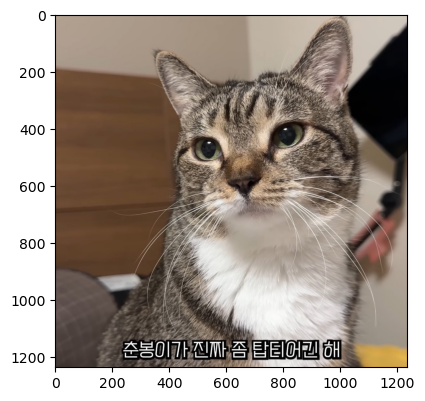

In [27]:
# 1. 고양이 사진 블러

cat_img_path = "cat.jpg"  # 고양이 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.show()

In [28]:
# 고양이 배경 블러처리
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])


input_tensor = transform(cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)).unsqueeze(0)


In [29]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy() #픽셀클래스 변환을 여기서 한

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 10.4 s, sys: 34.6 ms, total: 10.4 s
Wall time: 10.5 s


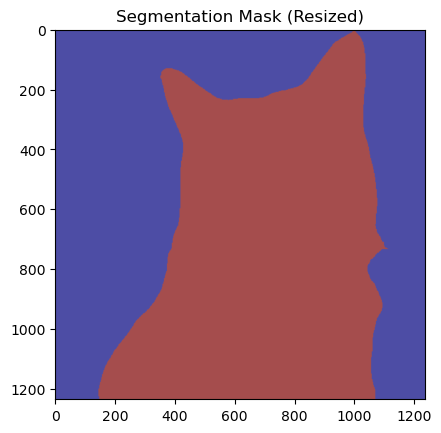

In [30]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [31]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([0, 8], dtype=uint8)

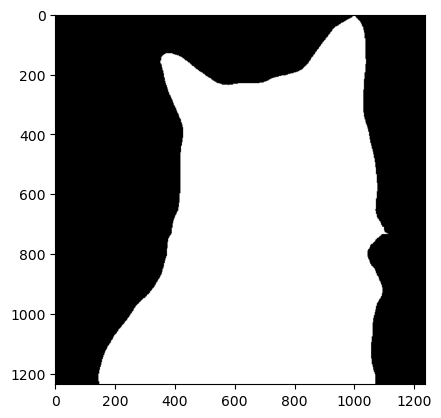

In [32]:
seg_map = (output_predictions_resized == 8)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

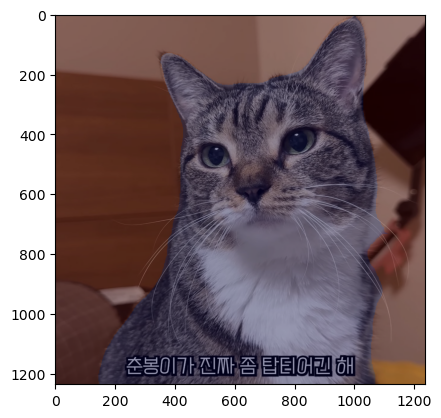

In [33]:
img_show = cv2.addWeighted(cat_img, 0.6, color_mask, 0.2, 0.0)

plt.imshow(img_show)
plt.show()

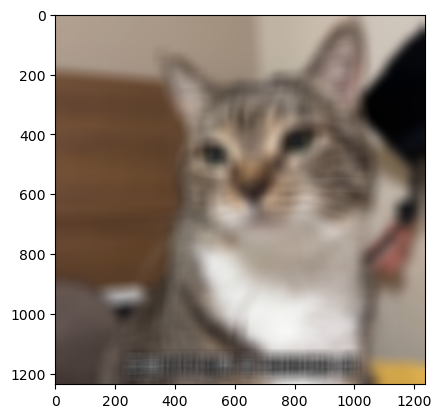

In [34]:
cat_img_blur = cv2.blur(cat_img, (50, 50))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cat_img_blur)
plt.show()

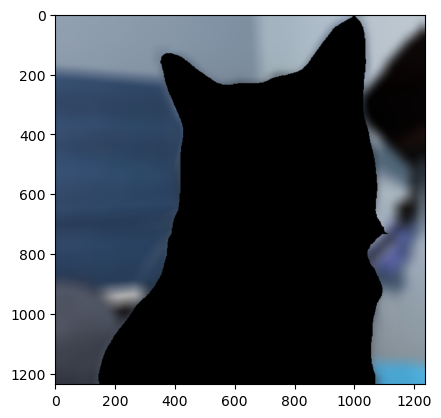

In [35]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(cat_img_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

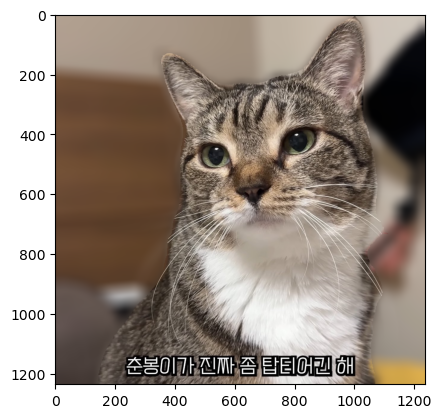

In [36]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, cat_img, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(img_concat)
plt.show()

In [37]:
# 2. 인물사진 블러

원본 bbt 이미지 크기: (398, 596, 3)
배경space 이미지 크기: (1794, 2500, 3)


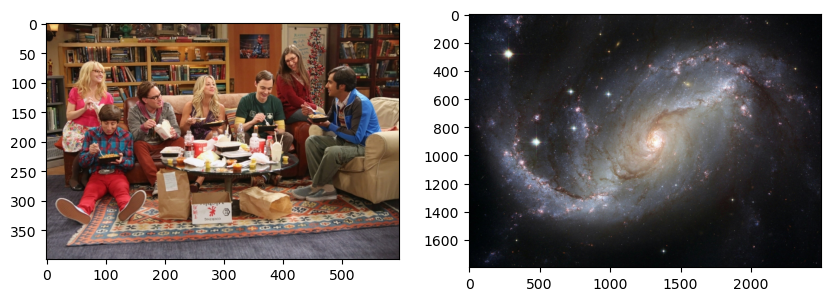

In [38]:
bbt_img_path = "bbt.jpg"  # 이미지를 준비해주세요
space_img_path = "space.jpg"  # 배경 이미지를 준비해주세요

bbt_img = cv2.imread(bbt_img_path)
space_img = cv2.imread(space_img_path)

bbt_img = cv2.cvtColor(bbt_img, cv2.COLOR_BGR2RGB)
space_img = cv2.cvtColor(space_img, cv2.COLOR_BGR2RGB)

print(f"원본 bbt 이미지 크기: {bbt_img.shape}")
print(f"배경space 이미지 크기: {space_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(bbt_img)

plt.subplot(1, 2, 2)
plt.imshow(space_img)

plt.show()

In [39]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(bbt_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [40]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (bbt_img.shape[1], bbt_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (398, 596)


In [41]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0  9 11 15 18]


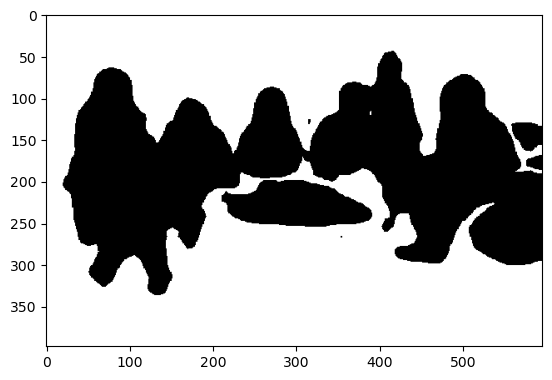

In [42]:
target_class_id = unique_classes[0]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

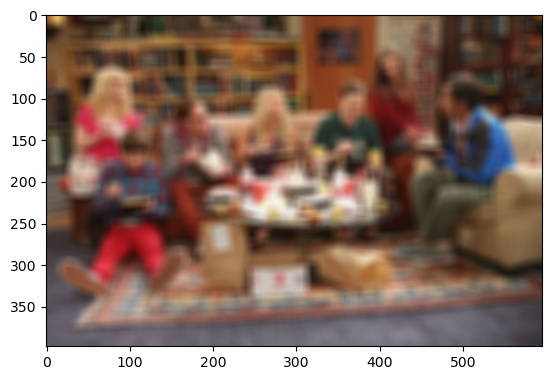

In [49]:
# 2. 사람이미지 배경 블러처리

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(bbt_img, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(img_orig_blur)
plt.show()

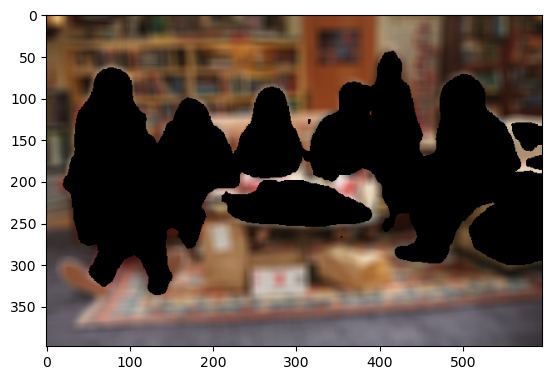

In [53]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, cv2.bitwise_not(img_bg_mask))
plt.imshow(img_bg_blur)
plt.show()

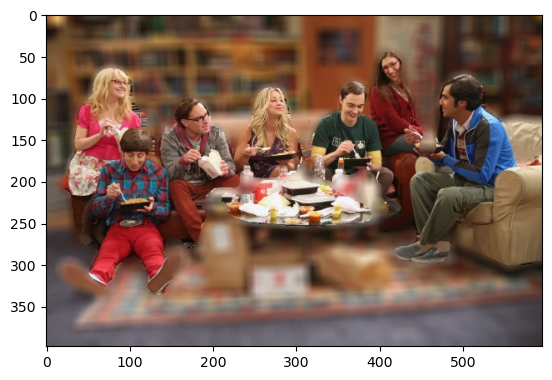

In [56]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_bg_blur, bbt_img)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(img_concat)
plt.show()

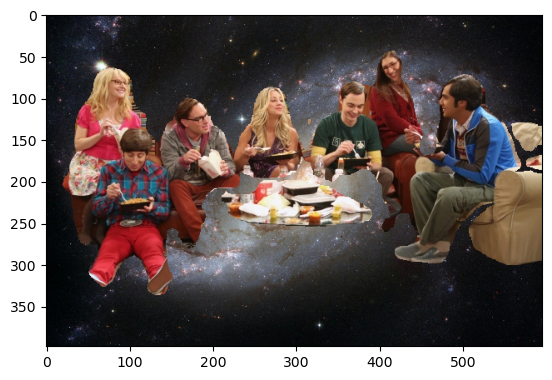

In [57]:
# 3. 크로마키

# 배경을 사람들 이미지 크기에 맞춤
space_img_resized = cv2.resize(space_img, (bbt_img.shape[1], bbt_img.shape[0]))

# 사람 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, space_img_resized, bbt_img)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

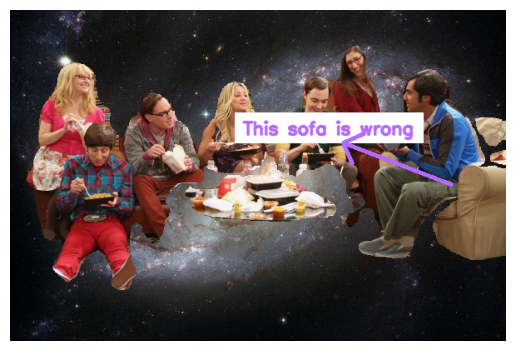

In [100]:
# 1️⃣ 배경 합성된 이미지 불러오기
cv2.imwrite("result_img.png", result_img)   # 저장
img = cv2.imread("result_img.png")          # 확장자 포함해서 읽기 (경로 확인!)

# 합성 결과가 메모리에 이미 있음 (result_img)
img = result_img.copy()

# 타입/범위 정리 (OpenCV는 uint8 기대)
if img.dtype != np.uint8:
    img = np.clip(img, 0, 255).astype(np.uint8)

# 만약 색이 뒤바뀌어 보이면 이 줄을 켜서 RGB→BGR로 바꿔서 OpenCV 기준으로 정렬
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

text = "This sofa is wrong"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale, thickness = 0.7, 2
position = (280, 150)  # (x, y)

# 텍스트 배경 박스
(text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)
cv2.rectangle(img, (position[0]-10, position[1]-text_h-10),
              (position[0]+text_w+10, position[1]+10), (255, 255, 255), -1)

# 텍스트
cv2.putText(img, text, position, font, font_scale, (180, 105, 255), thickness, cv2.LINE_AA)

# 화살표 (끝점=소파, 시작점=텍스트)
start_point = (position[0] + 250, position[1] + 60)  # 화살표 끝(소파쪽)
end_point   = (position[0] + 120, position[1] + 10)  # 화살표 시작(텍스트쪽)
cv2.arrowedLine(img, start_point, end_point, (180, 105, 255), 3, tipLength=0.2)

# 표시 (OpenCV는 BGR → matplotlib는 RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [114]:
# 인스턴스 세그멘테이션 사용

import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T



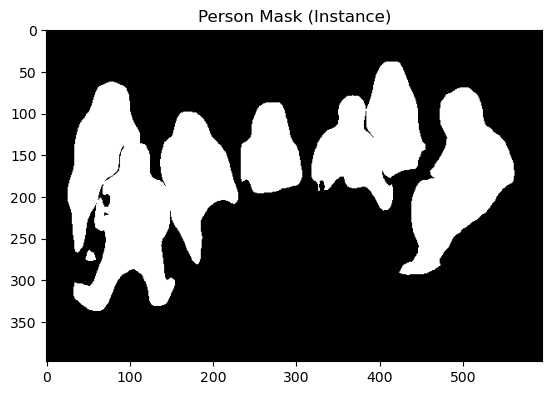

In [117]:
# 1. 모델 불러오기
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 2. 이미지 불러오기
img = Image.open("bbt.jpg").convert("RGB")
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img).unsqueeze(0)

# 3. 추론
with torch.no_grad():
    output = model(img_tensor)[0]

# 4. person(클래스 id=1)만 필터링
person_idx = output['labels'] == 1
person_masks = output['masks'][person_idx, 0] > 0.5

# 5. 여러 명이면 합치기
final_mask = person_masks.any(dim=0).cpu().numpy().astype(np.uint8) * 255

plt.imshow(final_mask, cmap='gray')
plt.title("Person Mask (Instance)")
plt.show()

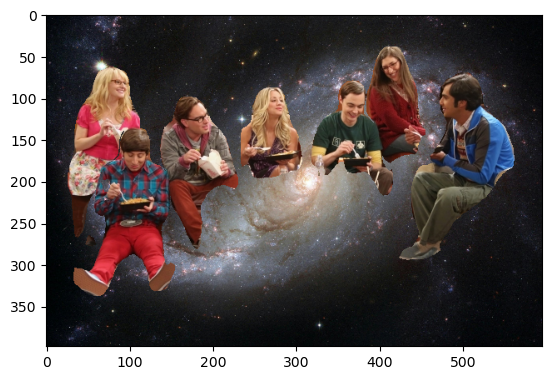

In [122]:
# 3. 크로마키

# 배경을 사람들 이미지 크기에 맞춤
space_img_resized = cv2.resize(space_img, (bbt_img.shape[1], bbt_img.shape[0]))

# 사람 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, bbt_img, space_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()